<h1>作业3（任务1:使用图卷积神经网络实现肿瘤分类）</h1>


<h2>简介数据，导入并清洗</h2>

<h3>1.数据简介</h3>

乳腺癌是全球妇女最常见的死因之一。早期发现有助于减少早期死亡人数。该数据集通过超声波扫描查看乳腺癌的医学影像。乳腺超声数据集分为三类：正常、良性和恶性图像。乳腺超声波图像与机器学习相结合，可在乳腺癌的分类、检测和分割方面产生很好的效果。
基线收集的数据包括25至75岁女性的乳腺超声图像。这些数据收集于2018年。患者人数为600名女性。数据集由780张图像组成，平均图像大小为500*500像素。图像为 PNG 格式。ground truth图像与mask图像一起呈现。图像分为三类，即正常、良性和恶性。

<h3>2.安装并导入相关包</h3>

In [42]:
#导入需要的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import time
import os
from PIL import Image
from sklearn.model_selection import train_test_split

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [5]:
import warnings

# Suppress DeprecationWarning and ResourceWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

<h3>3.数据预处理</h3>

In [6]:
#set input directory
input_dir = './personal/作业/Dataset_BUSI_with_GT/'

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [7]:
# Set the path to the output folder where overlayed images will be saved
output_dir = './personal/作业/Overlayed_images/'

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [8]:
labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

在输入数据之前将mask与原始图片合并，以优化模型表现

In [29]:
#function to overlay the image and mask
def overlay_and_save(image_path, mask_path, output_path):
    try:
        # Check if both image and mask files exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            # Open the actual image and mask image
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Ensure both images have the same color mode
            if image.mode != mask.mode:
                mask = mask.convert(image.mode)
            # Resize the images if their sizes don't match
            if image.size != mask.size:
                image = image.resize(mask.size)

            # Overlay the image with the mask
            overlayed = Image.blend(image, mask, alpha=0.5)
            
            # Save the overlayed image to the appropriate label folder
            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            #print(f"File not found for: {image_path} or {mask_path}. Skipping...")
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [ ]:
#导入数据，并将原始图片与mask合并
# Iterate through the subdirectories (benign, malignant, normal)
for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                # Construct the mask file path based on the naming convention
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

In [34]:
#统计各类别图片数据量
subfolder_file_count = {}

# 遍历指定路径下的所有子文件夹
for subfolder in os.listdir(output_dir):
    subfolder_path = os.path.join(output_dir, subfolder)
    
    # 计算子文件夹中的文件数量
    file_count = len(os.listdir(subfolder_path))
    subfolder_file_count[subfolder] = file_count

# 打印每个子文件夹及其包含的文件数目
for subfolder, count in subfolder_file_count.items():
    print(f"'{subfolder}' 包含 {count} 个文件。")

'benign' 包含 437 个文件。
'malignant' 包含 210 个文件。
'normal' 包含 133 个文件。


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

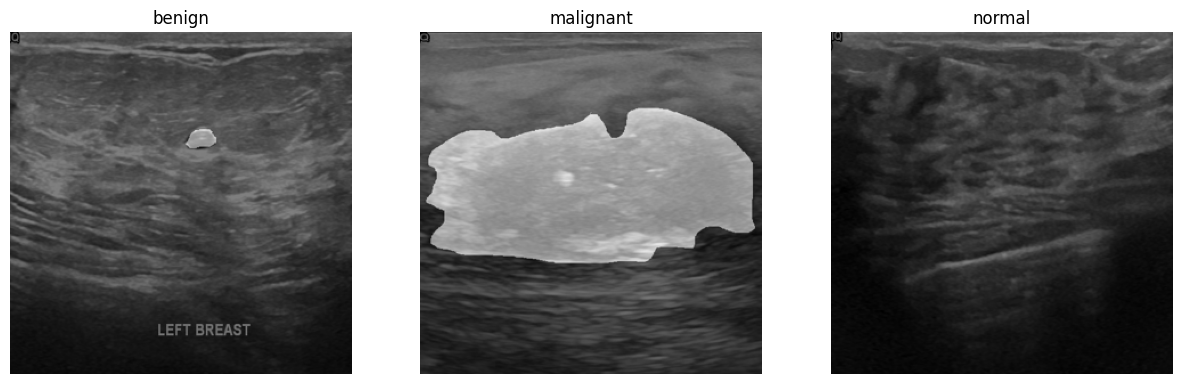

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [37]:
#展示合并后的图片
# 用于存储每个子文件夹的第一张图片的路径
first_images = []

# 遍历指定路径下的所有子文件夹
for subfolder in os.listdir(output_dir):
    subfolder_path = os.path.join(output_dir, subfolder)
    
    # 获取子文件夹中所有文件的列表
    files = os.listdir(subfolder_path)
    
    # 取出第一张图片的路径
    first_image_path = os.path.join(subfolder_path, files[0])
    first_images.append(first_image_path)

#设置图片大小
desired_width = 300
desired_height = 300
# 使用matplotlib展示图片
fig, axs = plt.subplots(1, len(first_images), figsize=(15, 5))  # 创建子图
for i, img_path in enumerate(first_images):
    image=Image.open(img_path)
    image=image.resize((desired_width, desired_height))
    axs[i].imshow(image)
    axs[i].set_title(f"{os.path.basename(os.path.dirname(img_path))}")
    axs[i].axis('off')  # 不显示坐标轴
plt.show()

In [9]:
# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 调整图像大小
    transforms.CenterCrop(224),
    transforms.ToTensor(),          # 转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化
])

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [10]:
#创建列表用于储存所有合并的图片
file_paths = []
labels = []

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [11]:
#将图片和图片名储存在列表中
for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [12]:
# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [13]:
#检查数据集
data.head(-5)

,Image_Path,Label
0,./personal/作业/Overlayed_images/benign/benign (...,benign
1,./personal/作业/Overlayed_images/benign/benign (...,benign
2,./personal/作业/Overlayed_images/benign/benign (...,benign
3,./personal/作业/Overlayed_images/benign/benign (...,benign
4,./personal/作业/Overlayed_images/benign/benign (...,benign
...,...,...
770,./personal/作业/Overlayed_images/normal/normal (...,normal
771,./personal/作业/Overlayed_images/normal/normal (...,normal
772,./personal/作业/Overlayed_images/normal/normal (...,normal
773,./personal/作业/Overlayed_images/normal/normal (...,normal


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

<h3>4.划分数据为训练集、验证集和测试集</h3>

In [14]:
#分割训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [15]:
# Define the paths for the train, validation, and test directories
train_dir = '/personal/作业/hw3/train'
val_dir = '/personal/作业/hw3/validation'
test_dir = '/personal/作业/hw3/test'

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [16]:
# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [ ]:
# Copy the images to the corresponding directories
import shutil
for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

In [28]:
# Create datasets for train, validation, and test
data_dir='/personal/作业/hw3/'
image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=transform
    )
    for x in ['train', 'validation', 'test']
}
# Specify batch size for dataloaders
batch_size = 8
# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
               for x in ['train', 'validation', 'test']}
# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
print("Dataset Sizes:", dataset_sizes)

Dataset Sizes: {'train': 562, 'validation': 100, 'test': 117}


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

<h2>模型简介，pytorch代码实现</h2>

使用图卷积神经网络模型，由三个图卷积层和两个全连接层组成。每个图卷积层后面都跟着一个最大池化层，用于特征提取和降维。模型的输入是具有num_features通道的图像，输出是类别概率分布，对应于num_classes个类别。  

模型的第一个图卷积层将输入特征从num_features映射到16个特征，第二个图卷积层将特征从16映射到32，第三个图卷积层进一步将特征从32映射到64。每个卷积层都使用大小为3的卷积核，并通过1的填充保持特征图的尺寸不变。池化层使用2x2的窗口和步长为2，用于下采样特征图。

在通过三个卷积层和池化层后，特征图被展平并通过两个全连接层进行分类。第一个全连接层将特征从642828映射到128，第二个全连接层将特征从128映射到最终的类别数num_classes。在全连接层之间使用ReLU激活函数来引入非线性。模型使用交叉熵损失函数（nn.CrossEntropyLoss）来计算预测和真实标签之间的损失，并采用Adam优化器（optim.Adam）来更新模型的权重，学习率设置为0.001。

<h3>5.搭建图卷积神经网络模型</h3>

In [19]:
#定义图卷积神经网络模型
class GCN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = nn.Conv2d(num_features, 16, kernel_size=3, padding=1)  # 图卷积层
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 图卷积层
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 图卷积层
        self.fc1 = nn.Linear(64 * 28 * 28, 128)  # 全连接层
        self.fc2 = nn.Linear(128, num_classes)  # 全连接层
        self.pool = nn.MaxPool2d(2, 2)  # 池化层

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)  # 展平
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [35]:
# 定义损失函数和优化器
num_features = 3  # 图像通道数
num_classes = len(image_datasets['train'].classes)  # 类别数
model = GCN(num_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [36]:
#训练模型
def train_model(dataloader, model, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in dataloader['train']:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader["train"])}')

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [37]:
#验证模型
def validate_model(dataloader, model, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader['validation']:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(dataloader['validation'].dataset)
    print(f'Validation Loss: {val_loss/len(dataloader["validation"])}, Accuracy: {100 * accuracy}%')

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [25]:
for images, labels in dataloaders['train']:
    print(images.size())  # 输出整个批次的尺寸信息
    print(labels.size())
    break  # 只查看第一批次的尺寸

torch.Size([8, 3, 224, 224])
torch.Size([8])


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [38]:
train_model(dataloaders, model, criterion, optimizer, num_epochs=18)
validate_model(dataloaders, model, criterion)

Epoch 1/18, Loss: 0.8244649862319651
Epoch 2/18, Loss: 0.5571120335182673
Epoch 3/18, Loss: 0.4436936248356188
Epoch 4/18, Loss: 0.35033202192313234
Epoch 5/18, Loss: 0.21360722909563443
Epoch 6/18, Loss: 0.14828530760665595
Epoch 7/18, Loss: 0.060738143288123776
Epoch 8/18, Loss: 0.03207984660681613
Epoch 9/18, Loss: 0.010005504383667025
Epoch 10/18, Loss: 0.0036163458842079117
Epoch 11/18, Loss: 0.0009551573019078359
Epoch 12/18, Loss: 0.00029809553947877286
Epoch 13/18, Loss: 0.0001894059469763511
Epoch 14/18, Loss: 0.00012809721697778232
Epoch 15/18, Loss: 9.095466196695141e-05
Epoch 16/18, Loss: 6.42408723463081e-05
Epoch 17/18, Loss: 4.918170533605468e-05
Epoch 18/18, Loss: 3.4770382830603767e-05
Validation Loss: 1.445595793604665, Accuracy: 78.0%


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

<h2>评估模型，与两种经典机器学习方法对比</h2>

<h3>6.评估图神经网络模型</h3>

In [39]:
# 将模型设置为评估模式
model.eval()

# 预测测试集
all_preds = []
all_labels = []
with torch.no_grad():
    for data in dataloaders['test']:
        # 假设你的数据加载器返回的特征和标签分别在data[0]和data[1]
        inputs, labels = data
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

              precision    recall  f1-score   support

           0       0.90      0.80      0.85        66
           1       0.69      0.81      0.75        31
           2       0.91      1.00      0.95        20

    accuracy                           0.84       117
   macro avg       0.83      0.87      0.85       117
weighted avg       0.85      0.84      0.84       117

Accuracy: 0.8376


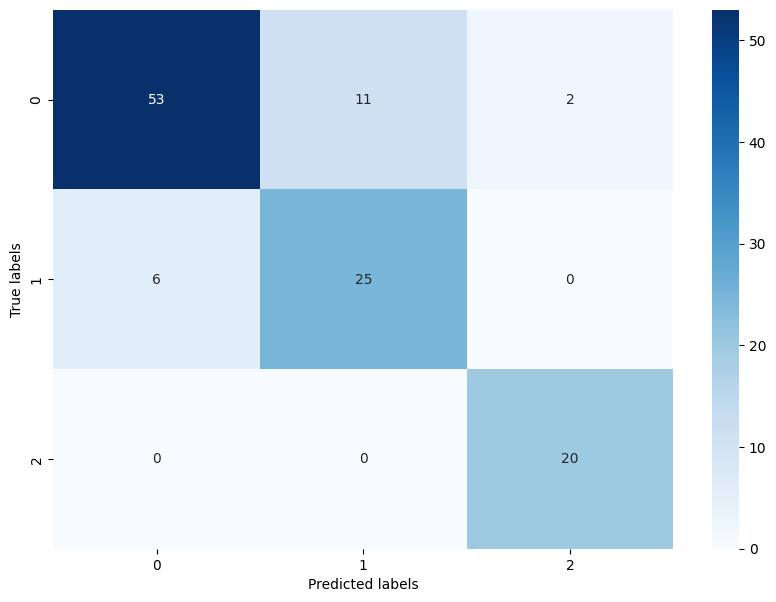

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# 计算分类报告
report = classification_report(all_labels, all_preds)
print(report)

# 计算混淆矩阵
conf_mat = confusion_matrix(all_labels, all_preds)

# 计算准确率
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# 绘制混淆矩阵
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

图卷积神经网络模型的准确率为84%

<h3>7.使用经典机器学习模型决策树分类

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [89]:
# 数据预处理和特征提取
def extract_features(dataloader):
    features = []
    labels = []
    for images, labels_batch in dataloader:
        images_np = images.numpy()
        for img, label in zip(images_np, labels_batch):
            #把img转化为灰度图
            img = np.transpose(img, (1, 2, 0))
            img_gray = rgb2gray(img)
            # 提取图像块作为特征
            patches = np.array([img_gray[i:i+8, j:j+8] for i in range(0, img.shape[0], 8) for j in range(0, img.shape[1], 8)])
            patches_feature = patches.flatten()
            # 提取HOG特征
            hog_feature = hog(img_gray, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2')
            # 将所有特征组合
            combined_features = np.concatenate((patches_feature, hog_feature))

            features.append(combined_features)
            labels.append(label)

    # 标准化特征
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    return np.array(features), np.array(labels)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [90]:
# 提取训练集和验证集特征
train_features, train_labels = extract_features(dataloaders['train'])
validation_features, validation_labels = extract_features(dataloaders['validation'])

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [91]:
# 划分训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [92]:
# 提取测试集特征
test_features, test_labels = extract_features(dataloaders['test'])

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [93]:
def decision_tree_model():
    grid = {
        'criterion' : ["gini", "entropy"],
        'max_depth' : [2,3,4,5],
        }
    estimator = DecisionTreeClassifier()
    cv_model = GridSearchCV(estimator=estimator,param_grid=grid,cv=5,n_jobs=-1)
    cv_model.fit(X=X_train,y=y_train)
    
    print(f'\nThe best parameters are : {cv_model.best_params_}\n------------------------------------------------------------------------------\n')
    print(f'\nThe train accuracy is equal to : {cv_model.best_score_}\n------------------------------------------------------------------------------\n')
    print(f'\nThe test accuracy is equal to : {cv_model.score(X=test_features,y=test_labels )}\n------------------------------------------------------------------------------\n')
    
    return cv_model.best_estimator_
    

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [94]:
# 测试集预测和评估
%time
DecisionTree_Model = decision_tree_model()
Y_prediction_DTM = DecisionTree_Model.predict(test_features)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs

The best parameters are : {'criterion': 'entropy', 'max_depth': 2}
------------------------------------------------------------------------------


The train accuracy is equal to : 0.5746566791510611
------------------------------------------------------------------------------


The test accuracy is equal to : 0.6239316239316239
------------------------------------------------------------------------------



Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

              precision    recall  f1-score   support

           0       0.60      0.98      0.75        66
           1       0.89      0.26      0.40        31
           2       0.00      0.00      0.00        20

    accuracy                           0.62       117
   macro avg       0.50      0.41      0.38       117
weighted avg       0.58      0.62      0.53       117

/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

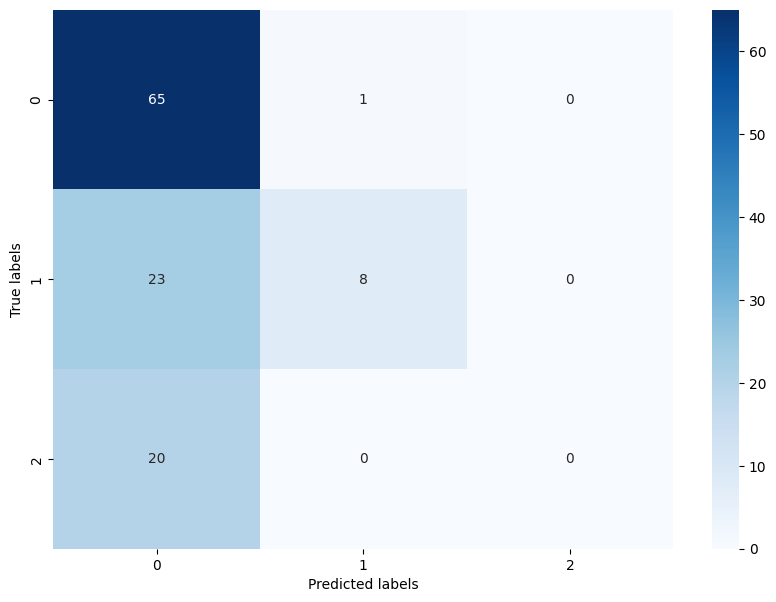

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [95]:
# 计算分类报告
report = classification_report(test_labels, Y_prediction_DTM)
print(report)
# 计算混淆矩阵
conf_mat1 = confusion_matrix(test_labels, Y_prediction_DTM)
# 绘制混淆矩阵
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

决策树模型的准确率为62%

<h3>8.使用经典机器学习模型随机森林进行分类</h3>

In [96]:
from sklearn.ensemble import RandomForestClassifier
def random_forest():
    
    grid = {
        
        'n_estimators' : [20,30,40],
        'criterion' : ["gini", "entropy"],
        'max_depth': [8,9,10],
        
        }
    
    estimator = RandomForestClassifier()
    cv_model = GridSearchCV(estimator=estimator,param_grid=grid,cv=5,n_jobs=-1)
    cv_model.fit(X=X_train,y=y_train)
    
    print(f'\nThe best parameters are : {cv_model.best_params_}\n------------------------------------------------------------------------------\n')
    print(f'\nThe train accuracy is equal to : {cv_model.best_score_}\n------------------------------------------------------------------------------\n')
    print(f'\nThe test accuracy is equal to : {cv_model.score(X=test_features,y=test_labels )}\n------------------------------------------------------------------------------\n')
    
    return cv_model.best_estimator_
    

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [97]:
%time
RandomForest_Model = random_forest()
Y_prediction_RFM = RandomForest_Model.predict(test_features)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.63 µs

The best parameters are : {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 40}
------------------------------------------------------------------------------


The train accuracy is equal to : 0.7039450686641697
------------------------------------------------------------------------------


The test accuracy is equal to : 0.8205128205128205
------------------------------------------------------------------------------



Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

              precision    recall  f1-score   support

           0       0.81      0.91      0.86        66
           1       0.87      0.65      0.74        31
           2       0.80      0.80      0.80        20

    accuracy                           0.82       117
   macro avg       0.83      0.78      0.80       117
weighted avg       0.82      0.82      0.82       117



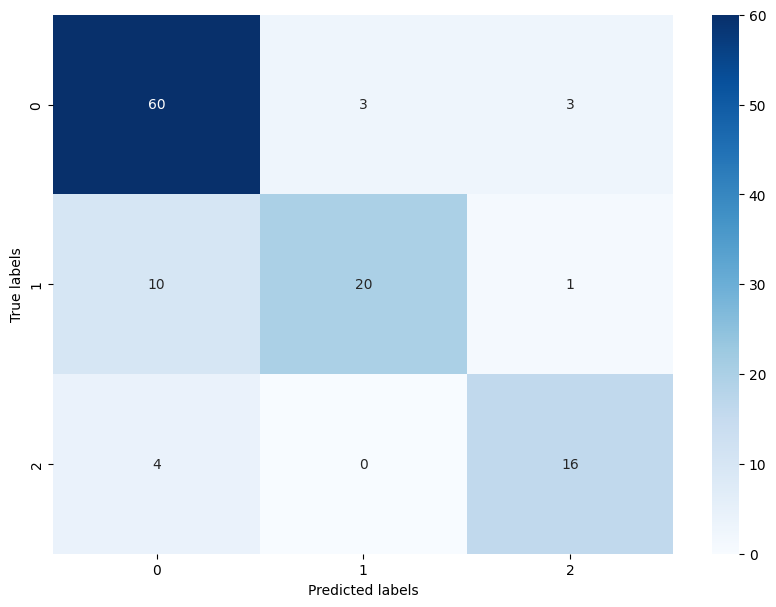

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [98]:
# 计算分类报告
report = classification_report(test_labels, Y_prediction_RFM)
print(report)
# 计算混淆矩阵
conf_mat2 = confusion_matrix(test_labels, Y_prediction_RFM)
# 绘制混淆矩阵
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

随机森林模型的准确率为82%

<h3>9.总结比较</h3>

在图像分类任务中，使用决策树和随机森林两个简单机器学习模型与图卷积神经网络模型比较。   

图卷积神经网络：整体表现较为均衡，准确率为83.76%。
在类别0上表现最佳，精确度和召回率分别为90%和80%，F1分数为85%。
在类别1上表现稍弱，精确度为69%，召回率为81%，F1分数为75%。
在类别2上表现非常出色，精确度、召回率和F1分数均为91%、100%和95%。
宏观平均和加权平均指标都显示出较好的性能，分别为83%和85%。

决策树：整体准确率较低，为62%。
在类别0上表现尚可，精确度为60%，召回率为98%，F1分数为75%。
在类别1上表现较差，精确度和召回率分别为89%和26%，F1分数为40%。
在类别2上表现极差，精确度、召回率和F1分数均为0%。
宏观平均和加权平均指标都显示出较差的性能，分别为50%和58%。

随机森林：整体表现较好，准确率为82%。
在类别0上表现良好，精确度和召回率分别为81%和91%，F1分数为86%。
在类别1上表现尚可，精确度和召回率分别为87%和65%，F1分数为74%。
在类别2上表现均衡，精确度、召回率和F1分数均为80%。
宏观平均和加权平均指标都显示出较好的性能，分别为83%和82%。

图卷积神经网络在所有模型中表现最佳，尤其是在类别2上的表现非常出色，整体准确率也最高。决策树模型在类别2上的表现极差，导致其整体性能和宏观平均性能都较差。随机森林模型在所有类别上都显示出较好的均衡性能，整体准确率也较高。   

综上所述，图卷积神经网络在肿瘤图像分类任务上表现最优，随机森林次之，而决策树的表现则不尽如人意。这可能与图卷积神经网络在处理图像数据时能够捕捉到更复杂的特征和结构有关，而决策树由于其简单的决策规则，在处理复杂数据时容易过拟合或欠拟合。

<h1>作业4（任务 2：利用 UNET 实现图像中的肿瘤区域识别）

<h2>简介数据，导入并清洗

**数据简介** 本数据集有三个主要类别：良性（benign）、恶性（malignant）和正常（normal）。每个类别都包含了相应的医学图像ground truth及其对应的分割掩码（mask）。数据集涵盖了不同类型的肿瘤图像，包括良性和恶性肿瘤，以及正常组织图像，这有助于模型学习区分肿瘤和正常组织的特征。每个类别中的图像都有对应的掩码，掩码精确地标记了肿瘤区域，在监督学习中提供了训练模型的标签。在灰度图中，肿瘤部分多为白色，对于mask的白色部分，其他区域为深浅不一的灰色，对应mask的黑色区域。正常组中不存在肿瘤区域，因此mask全部为黑色。

In [36]:
import os
import numpy as np
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [38]:
import cv2

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [39]:
import warnings
warnings.filterwarnings("ignore")

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [40]:
import random

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [41]:
#set input directory
input_dir = './personal/作业/Dataset_BUSI_with_GT/'

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [42]:
#读取数据
masks = glob.glob("./personal/作业/Dataset_BUSI_with_GT/*/*_mask.png")

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [43]:
masks[1:4]

['./personal/作业/Dataset_BUSI_with_GT/benign/benign (10)_mask.png',
 './personal/作业/Dataset_BUSI_with_GT/benign/benign (100)_mask.png',
 './personal/作业/Dataset_BUSI_with_GT/benign/benign (101)_mask.png']

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [44]:
images = [mask_images.replace("_mask", "") for mask_images in masks]

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [45]:
series = list(zip(images, masks))

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [46]:
series[:4]

[('./personal/作业/Dataset_BUSI_with_GT/benign/benign (1).png',
  './personal/作业/Dataset_BUSI_with_GT/benign/benign (1)_mask.png'),
 ('./personal/作业/Dataset_BUSI_with_GT/benign/benign (10).png',
  './personal/作业/Dataset_BUSI_with_GT/benign/benign (10)_mask.png'),
 ('./personal/作业/Dataset_BUSI_with_GT/benign/benign (100).png',
  './personal/作业/Dataset_BUSI_with_GT/benign/benign (100)_mask.png'),
 ('./personal/作业/Dataset_BUSI_with_GT/benign/benign (101).png',
  './personal/作业/Dataset_BUSI_with_GT/benign/benign (101)_mask.png')]

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [47]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])
    
    f, axarr = plt.subplots(1, 3, figsize=(5, 5))
    
    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel('Axial View', fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

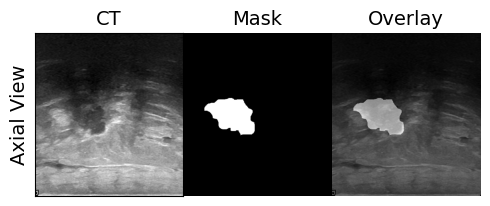

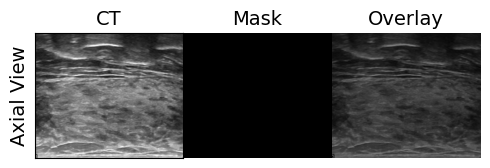

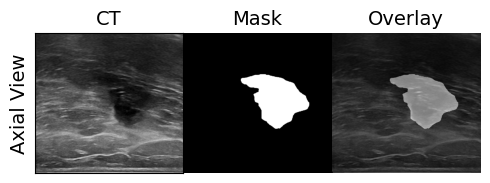

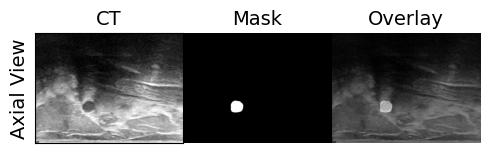

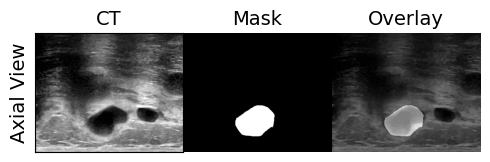

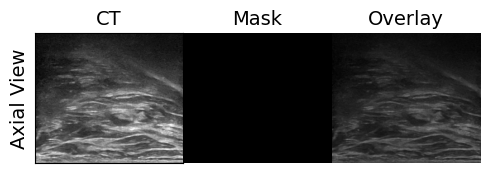

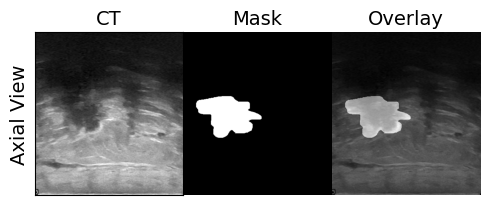

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [48]:
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_train_label(series[image])

In [49]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [50]:
dataset

,image_path,mask_path
0,./personal/作业/Dataset_BUSI_with_GT/benign/beni...,./personal/作业/Dataset_BUSI_with_GT/benign/beni...
1,./personal/作业/Dataset_BUSI_with_GT/benign/beni...,./personal/作业/Dataset_BUSI_with_GT/benign/beni...
2,./personal/作业/Dataset_BUSI_with_GT/benign/beni...,./personal/作业/Dataset_BUSI_with_GT/benign/beni...
3,./personal/作业/Dataset_BUSI_with_GT/benign/beni...,./personal/作业/Dataset_BUSI_with_GT/benign/beni...
4,./personal/作业/Dataset_BUSI_with_GT/benign/beni...,./personal/作业/Dataset_BUSI_with_GT/benign/beni...
...,...,...
775,./personal/作业/Dataset_BUSI_with_GT/normal/norm...,./personal/作业/Dataset_BUSI_with_GT/normal/norm...
776,./personal/作业/Dataset_BUSI_with_GT/normal/norm...,./personal/作业/Dataset_BUSI_with_GT/normal/norm...
777,./personal/作业/Dataset_BUSI_with_GT/normal/norm...,./personal/作业/Dataset_BUSI_with_GT/normal/norm...
778,./personal/作业/Dataset_BUSI_with_GT/normal/norm...,./personal/作业/Dataset_BUSI_with_GT/normal/norm...


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

<h2>简介模型，pytorch代码实现

搭建U-net模型实现肿瘤图像分割。模型由Encoder、Bottleneck、Decoder、Classification Layer等部分组成。    

编码器（Encoder）：包含四个编码器层，每个层都由一个ConvBlock组成，该块由两个卷积层、批量归一化层和ReLU激活函数组成，后面跟着一个Dropout层以减少过拟合。这些编码器层逐步增加特征通道数，同时通过最大池化层（MaxPool2d）降低空间维度。

瓶颈层（BottleNeck）：在编码器层之后，使用一个额外的ConvBlock来进一步处理特征，这个瓶颈层有助于在模型的中间部分捕获更复杂的特征。

解码器（Decoder）：模型的解码器部分包含四个解码器层，每个解码器层都有一个转置卷积层（ConvTranspose2d）用于上采样，以及一个ConvBlock来进一步处理特征。解码器层逐步减少特征通道数，并与编码器层对应的特征图进行拼接（Skip Connection），这有助于恢复图像的空间细节。

分类层（Classification Layer）：使用一个1x1卷积层来将特征图映射到目标类别数（在这种情况下是1，用于二分类问题），并应用Sigmoid激活函数来获取每个像素属于肿瘤的概率。

训练器（Trainer）：管理模型的训练过程，包括计算损失、Dice系数以及保存最佳模型。这个类还包括了训练和验证过程中的日志记录和性能指标跟踪。

In [51]:
train, test= train_test_split(dataset, test_size=0.25)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [52]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (585, 2)
Test shape: (195, 2)


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [53]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomImageMaskDataset(Dataset):
    np.random.seed(42)
    torch.manual_seed(42)
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L') 
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [54]:
# Define transformations with selected augmentation techniques and normalization for grayscale
image_size = 128
    
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [55]:
# Create datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [56]:
# Create DataLoaders
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [57]:
for batch in train_dataloader:
    # Assuming your dataset returns a tuple (inputs, targets)
    inputs, targets = batch
    
    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [33]:
device

device(type='cpu')

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [59]:
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(ConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()
        
        self.dropout = nn.Dropout(dropout)
        
        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()
    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)
        
        x = self.dropout(x)
        
        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)

        return x

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [60]:
class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return x, p

class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        self.conv2d_1 = ConvBlock(output_channel*2, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, skip):
        x = self.conv_t(x)
        x = torch.cat([x, skip], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [61]:
class Unet(nn.Module):

    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, 0.07)
        self.encoder_2 = Encoder(64, 128, 0.08)
        self.encoder_3 = Encoder(128, 256, 0.09)
        self.encoder_4 = Encoder(256, 512, 0.1)

        self.conv_block = ConvBlock(512, 1024, 0.11)

        self.decoder_1 = Decoder(1024, 512, 0.1)
        self.decoder_2 = Decoder(512, 256, 0.09)
        self.decoder_3 = Decoder(256, 128, 0.08)
        self.decoder_4 = Decoder(128, 64, 0.07)
        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid() 

    def forward(self, x):

        """ ------ Encoder ------"""
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)

        """ ------ BottleNeck ------"""
        x5 = self.conv_block(p4)
        """ ------ Decoder ------"""
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)
        
        """ ------ Final Layer ------"""
        x_final = self.cls(x9)
        x_final = self.relu(x_final)

        return x_final

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [62]:
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15
        # Lists to store training and validation metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model and its metrics
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0

    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice
    
    def iou(self, pred_mask, true_mask):
        intersection = torch.logical_and(pred_mask, true_mask).sum().item()
        union = torch.logical_or(pred_mask, true_mask).sum().item()
        iou_score = intersection / union if union != 0 else 0.0
        return iou_score

    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)

    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training loop
            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')

                # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)

            # Save best model
            self.save_best_model(epoch + 1, avg_val_dice)

    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [63]:
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)
    
    return bce_score + dice_score

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [64]:
unet = Unet(1).to(device)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [65]:
learning_rate = 0.0001
weight_decay = 1e-6  # Regularization term to prevent overfitting

optimizer = optim.Adam(unet.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = Trainer(model=unet, num_epochs=30, optimizer=optimizer, criterion=bce_dice_loss, device=device)

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [66]:
trainer.train(train_dataloader, test_dataloader)
metrics = trainer.get_metrics()

Epoch [1/30], Step [15/37], Loss: 1.4888, Dice Coef: 0.1515
Epoch [1/30], Step [30/37], Loss: 1.3454, Dice Coef: 0.2174
Epoch [1/30], Train Loss: 1.4358, Val Loss: 1.3215
Epoch [1/30], Train Dice: 0.1755, Val Dice: 0.1429
Epoch [2/30], Step [15/37], Loss: 1.1486, Dice Coef: 0.2900
Epoch [2/30], Step [30/37], Loss: 1.0246, Dice Coef: 0.3325
Epoch [2/30], Train Loss: 1.1825, Val Loss: 1.1141
Epoch [2/30], Train Dice: 0.2429, Val Dice: 0.2530
Epoch [3/30], Step [15/37], Loss: 1.1257, Dice Coef: 0.2647
Epoch [3/30], Step [30/37], Loss: 1.2274, Dice Coef: 0.1694
Epoch [3/30], Train Loss: 1.1030, Val Loss: 1.2497
Epoch [3/30], Train Dice: 0.2726, Val Dice: 0.2582
Epoch [4/30], Step [15/37], Loss: 0.9912, Dice Coef: 0.3296
Epoch [4/30], Step [30/37], Loss: 1.0681, Dice Coef: 0.2597
Epoch [4/30], Train Loss: 1.0681, Val Loss: 1.1456
Epoch [4/30], Train Dice: 0.2860, Val Dice: 0.2677
Epoch [5/30], Step [15/37], Loss: 0.9649, Dice Coef: 0.3373
Epoch [5/30], Step [30/37], Loss: 0.9019, Dice Coef:

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

<h2>评估模型</h2>

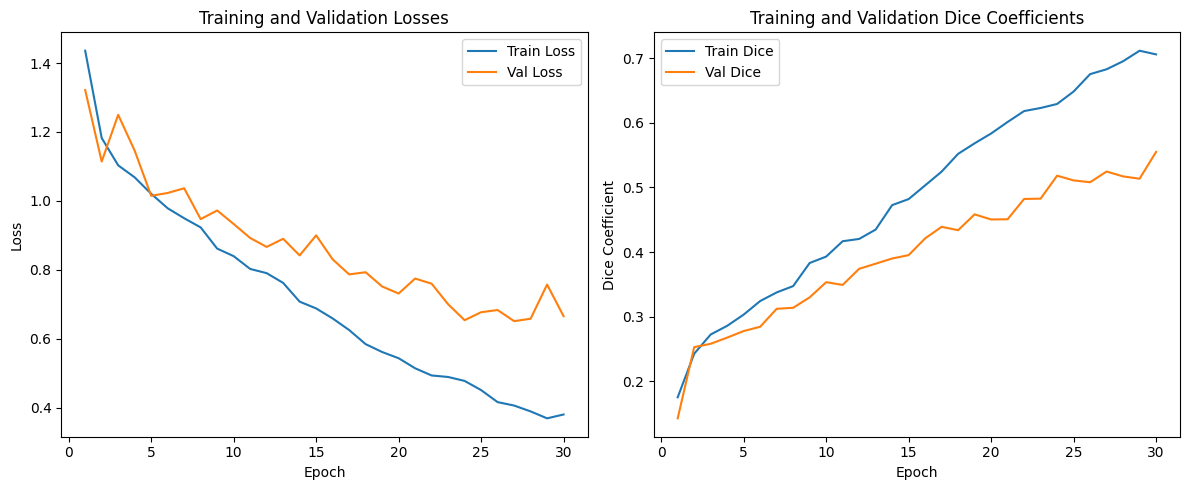

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [67]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_metrics(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    # Convert tensors to NumPy arrays
    train_losses_np = metrics['train_losses']
    val_losses_np = metrics['val_losses']
    train_dices_np = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dices_np = [to_numpy(dice) for dice in metrics['val_dices']]

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, label='Train Loss')
    plt.plot(epochs, val_losses_np, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficients
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dices_np, label='Train Dice')
    plt.plot(epochs, val_dices_np, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)


In [68]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

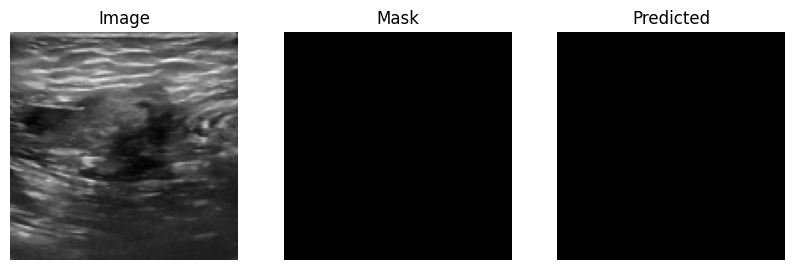

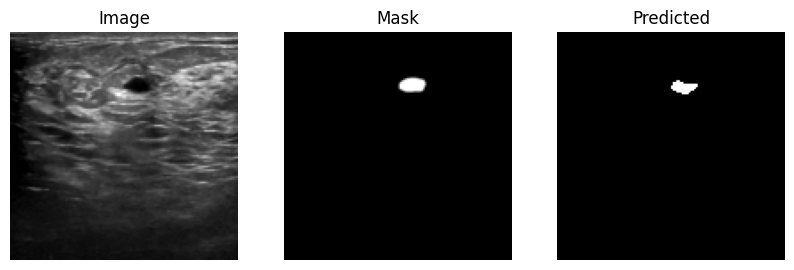

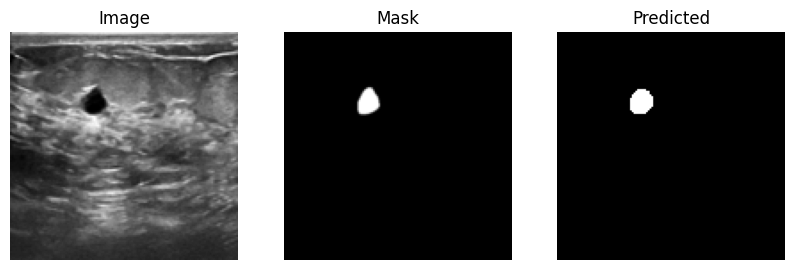

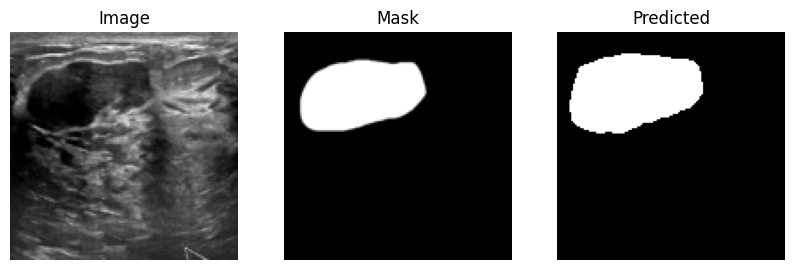

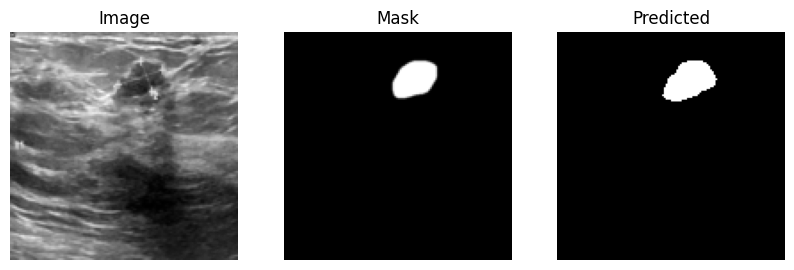

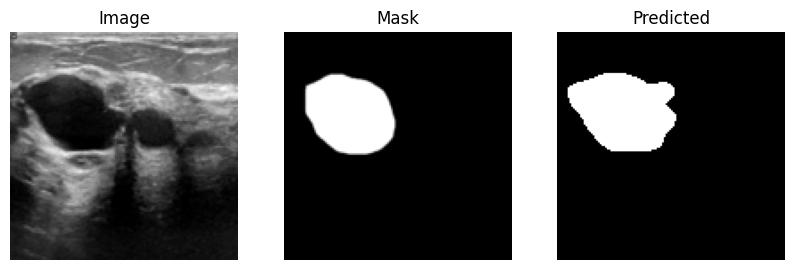

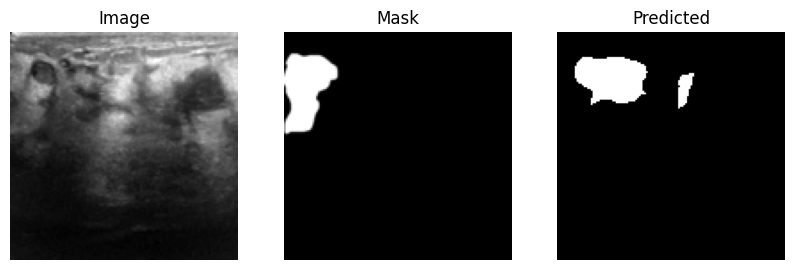

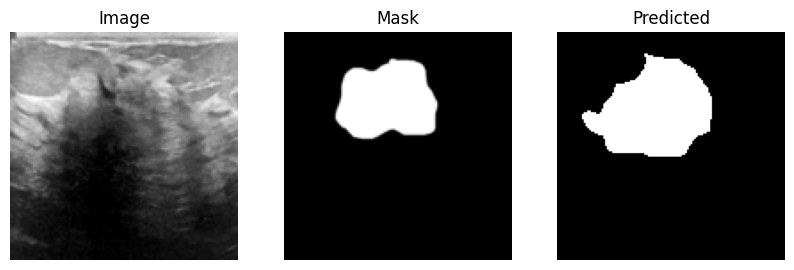

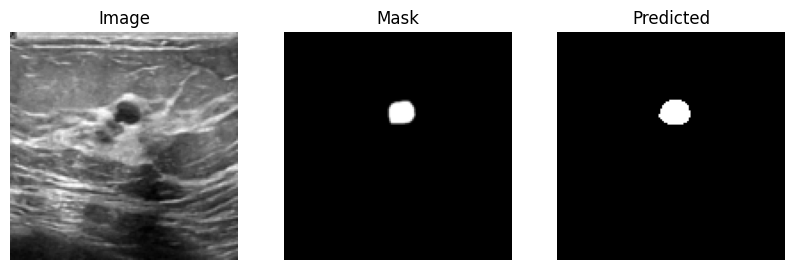

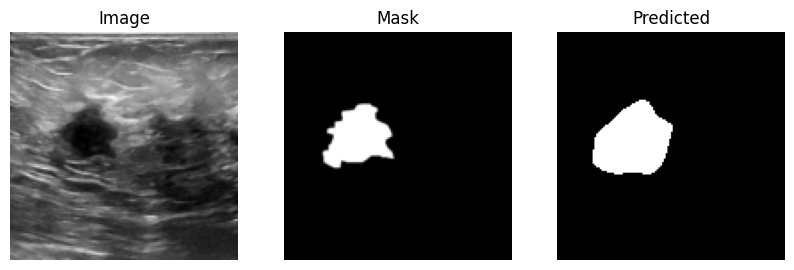

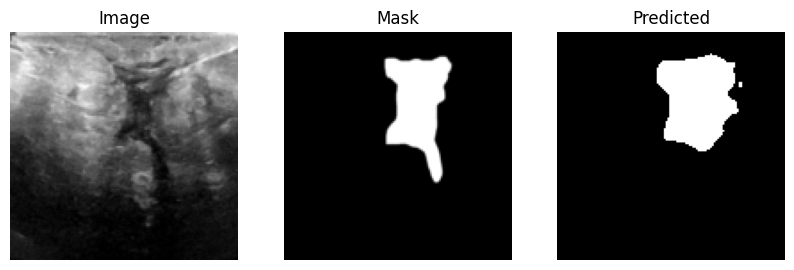

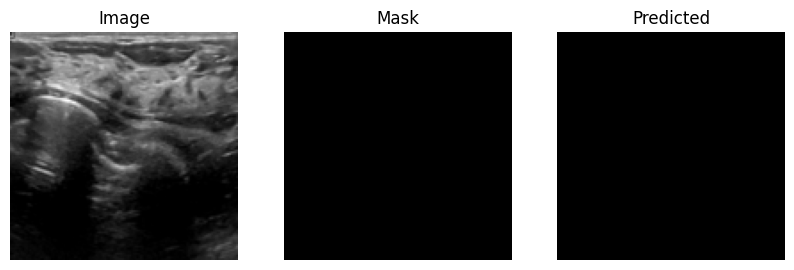

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [71]:
#epoch 30
for i in [2, 17, 31, 55, 77, 98, 120, 130, 146, 167, 183, 200]:
    image = train_dataset[i][0]
    mask = train_dataset[i][1]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)

由上图，模型预测结果与mask结果整体比较一致，其中模型对于边缘较为规则的圆形或椭圆形区域的预测较为准确；但是模型对于边缘有多处突出的区域预测结果准确度下降；模型能够准确预测不存在肿瘤区域的图像。

由Loss和Dice系数图像，
由于计算资源限制，使用30个epoch对模型进行训练，其中train loss和validation loss整体符合下降趋势。从第1个epoch到第30个epoch，损失值显著降低，这表明模型在训练集上的性能得到了提升。训练损失和验证损失之间的差距不大，这表明模型没有过拟合到训练数据     

**Dice系数**是衡量模型分割效果的一个重要指标，其值越接近1，表示模型的分割效果越好。从第1个epoch到第30个epoch，训练Dice系数和验证Dice系数都在逐渐提高，这表明模型的分割精度在不断提升。到了第30个epoch，validation 的Dice系数达到了0.5549，这是一个相对较高的值，表明模型在验证集上的分割效果较好。由于训练Dice系数和验证Dice系数之间的差距不大，这表明模型在训练集和验证集上都有较好的表现，具有较好的泛化能力。

总结：使用U-net实现肿瘤图像分割并使用Dice系数评估模型，模型的肿瘤分割表现整体较好。

<h1>参考资料</h1>



1.Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.     
2.https://www.kaggle.com/code/alkanerturan/breastcancer-imageclassificationwithcnn-98-accur      
3.https://www.kaggle.com/code/elrond012/breast-cancer-classification1#approach-2      
4.https://www.kaggle.com/code/sinatavakoli/breast-cancer-classification     
5.https://www.kaggle.com/code/parsakh/breast-cancer-image-segmentation-unet-pytorch

<h1>附加题</h1>

**1.总结文献**
有 155 幅图像（包括相似图像）是数据集中其他图像的副本，占整个数据集的 19%。70 幅图像（占整个数据集的 8%以上）显示了乳房以外的其他结构，如腋窝等。至少有 19 张图像（超过 2%）的病变类型（正常、良性、恶性）存在疑问。剔除列出的不准确之处后，收集到的图像最多只有 529 张。还应注意的是，大量图像在相关区域内包含注释（尺寸、描述），会影响机器学习过程中对肿瘤区域的处理，去除这些注释后，只剩下 399 个图像。此外，原数据集并没有区分训练集和测试集。